# Problem 1 Multimodal Image–Audio Digit Classification under Noisy Conditions

In this notebook, I provide the solutions to the problem 1 of the NORA Summer School exam.

The sections are as follows:


## Image-Only Classification

- A simple CNN with two convolutional layers and pooling layers.

## Audio-Only Classification

- A simple MLP with two fully connected layers. ??

## Unimodal Performance Comparison

## Multi-Modal Fusion Overview

## Fusion Strategy 1 Multi-Modal Model

## Fusion Strategy 2 Multi-Modal Model

## Representation Visualization

- Visualize the fused representations using PCA or t-SNE.





# Imports

In [142]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torch.nn.functional as F
from sklearn.decomposition import PCA
from sklearn.manifold     import TSNE
import matplotlib.pyplot   as plt
import numpy as np
import tqdm

In [2]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
    
print(device)

mps


# Load Datasets

 train images : torch.Size([17560, 1, 28, 28]) torch.float32
 train img lbl: torch.Size([17560]) torch.int64
 train audio  : torch.Size([17560, 1, 8000]) torch.float64
 train aud lbl: torch.Size([17560]) torch.int64
  test images : torch.Size([5859, 1, 28, 28]) torch.float32
  test img lbl: torch.Size([5859]) torch.int64
  test audio  : torch.Size([5859, 1, 8000]) torch.float64
  test aud lbl: torch.Size([5859]) torch.int64


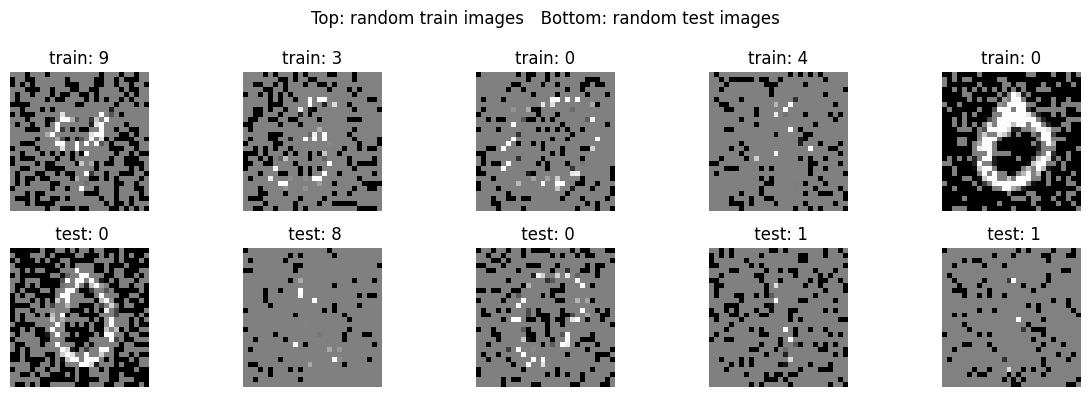

 one train-audio sample: torch.Size([1, 8000]) torch.float64


In [ ]:
train_imgs   = torch.load('data/training_images.pth', weights_only=False)          
train_img_lbl = torch.load('data/training_images_labels.pth', weights_only=False)  
train_audio  = torch.load('data/training_audio.pth', weights_only=False)           
train_aud_lbl = torch.load('data/training_audio_labels.pth', weights_only=False)   

test_imgs    = torch.load('data/test_images.pth', weights_only=False)              
test_img_lbl  = torch.load('data/test_images_labels.pth', weights_only=False)      
test_audio   = torch.load('data/test_audio.pth', weights_only=False)               
test_aud_lbl  = torch.load('data/test_audio_labels.pth', weights_only=False)       

print(" train images :", train_imgs.shape, train_imgs.dtype)
print(" train img lbl:", train_img_lbl.shape, train_img_lbl.dtype)
print(" train audio  :", train_audio.shape, train_audio.dtype)
print(" train aud lbl:", train_aud_lbl.shape, train_aud_lbl.dtype)

print("  test images :", test_imgs.shape, test_imgs.dtype)
print("  test img lbl:", test_img_lbl.shape, test_img_lbl.dtype)
print("  test audio  :", test_audio.shape, test_audio.dtype)
print("  test aud lbl:", test_aud_lbl.shape, test_aud_lbl.dtype)

# 3) PLOT 5 RANDOM TRAIN + 5 RANDOM TEST IMAGES
fig, axes = plt.subplots(2, 5, figsize=(12, 4))
for i in range(5):
    # train
    idx_t = torch.randint(0, len(train_imgs), (1,)).item()
    axes[0, i].imshow(train_imgs[idx_t,0], cmap='gray')
    axes[0, i].set_title(f"train: {train_img_lbl[idx_t].item()}")
    axes[0, i].axis('off')
    # test
    idx_te = torch.randint(0, len(test_imgs), (1,)).item()
    axes[1, i].imshow(test_imgs[idx_te,0], cmap='gray')
    axes[1, i].set_title(f" test: {test_img_lbl[idx_te].item()}")
    axes[1, i].axis('off')

plt.suptitle("Top: random train images Bottom: random test images")
plt.tight_layout()
plt.show()

print(" one train-audio sample:", train_audio[0].shape, train_audio.dtype)

In [31]:
mean = train_imgs.mean()
std = train_imgs.std()
print(f"mean={mean:.4f}, std={std:.4f}")

mean=-0.7350, std=2.6681


# Dataloaders

In [110]:

mean = -0.7
std = 2.7 

train_img_transforms = transforms.Compose([
    transforms.RandomRotation(15),                           
    transforms.RandomAffine(degrees=0, translate=(0.1,0.1)),
    transforms.Normalize((mean,), (std,)),             
])

test_img_transforms = transforms.Compose([
    transforms.Normalize((mean,), (std,)),
])

train_audio = train_audio.float()
test_audio  = test_audio.float()

train_aud_ds = TensorDataset(train_audio, train_aud_lbl)
test_aud_ds  = TensorDataset(test_audio,  test_aud_lbl)

class ImageDataset(Dataset):
    def __init__(self, imgs, labels, transform=None):
        self.imgs      = imgs     # Tensor [N,1,28,28]
        self.labels    = labels   # Tensor [N]
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img   = self.imgs[idx]        # still a Tensor
        lbl   = self.labels[idx].item()
        if self.transform:
            img = self.transform(img)
        return img, lbl

train_img_ds = ImageDataset(train_imgs, train_img_lbl, transform=train_img_transforms)
test_img_ds  = ImageDataset(test_imgs, test_img_lbl,  transform=test_img_transforms)

# for fusion
class PairedDataset(Dataset):
    def __init__(self, imgs, audios, labels, transform=None):
        """
        imgs:   Tensor[N,1,28,28]
        audios: Tensor[N,1,8000]
        labels: Tensor[N]
        """
        print("PairedDataset: imgs, audios, labels shapes:", imgs.shape, audios.shape, labels.shape)
        assert len(imgs) == len(audios) == len(labels)
        self.imgs   = imgs
        self.audios = audios
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img   = self.imgs[idx]       # still a Tensor [1,28,28]
        if self.transform:
            img = self.transform(img)
        return (img, self.audios[idx]), self.labels[idx]

train_fused_ds = PairedDataset(train_imgs, train_audio, train_img_lbl, transform=train_img_transforms)
test_fused_ds  = PairedDataset(test_imgs,  test_audio,  test_img_lbl, transform=test_img_transforms)

batch_size = 64

# Image-only loaders
train_img_loader = DataLoader(train_img_ds, batch_size=batch_size, shuffle=True)
test_img_loader  = DataLoader(test_img_ds,  batch_size=batch_size, shuffle=False)
# Audio-only loaders
train_aud_loader = DataLoader(train_aud_ds, batch_size=batch_size, shuffle=True)
test_aud_loader  = DataLoader(test_aud_ds,  batch_size=batch_size, shuffle=False)
# Fused (image+audio) loaders
train_fused_loader = DataLoader(train_fused_ds, batch_size=batch_size, shuffle=True)
test_fused_loader  = DataLoader(test_fused_ds,  batch_size=batch_size, shuffle=False)

PairedDataset: imgs, audios, labels shapes: torch.Size([17560, 1, 28, 28]) torch.Size([17560, 1, 8000]) torch.Size([17560])
PairedDataset: imgs, audios, labels shapes: torch.Size([5859, 1, 28, 28]) torch.Size([5859, 1, 8000]) torch.Size([5859])


## View Loaders

### Train Loader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7394655..1.2501509].


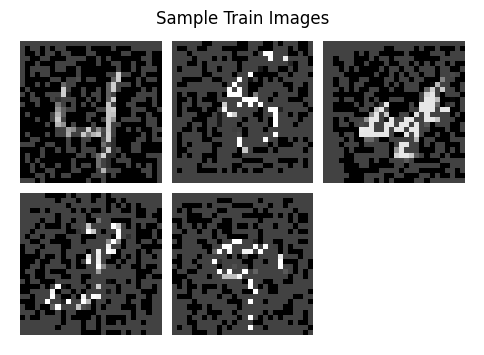

Labels for these images: [4, 6, 4, 3, 9]
Test batch — images tensor shape: torch.Size([64, 1, 28, 28])
Test batch — labels tensor shape: torch.Size([64])


In [87]:
# Visualize a few training images
imgs, labels = next(iter(train_img_loader))

grid = torchvision.utils.make_grid(imgs[:5], nrow=3, normalize=False, pad_value=1)

plt.figure(figsize=(6,6))
plt.imshow(grid.permute(1,2,0))
plt.title("Sample Train Images")
plt.axis('off')
plt.show()

print("Labels for these images:", labels[:5].tolist())

test_imgs2, test_lbls = next(iter(test_img_loader))
print(f"Test batch — images tensor shape: {test_imgs2.shape}")
print(f"Test batch — labels tensor shape: {test_lbls.shape}")

Audio batch shape: torch.Size([64, 1, 8000])
Audio Labels shape: torch.Size([64])


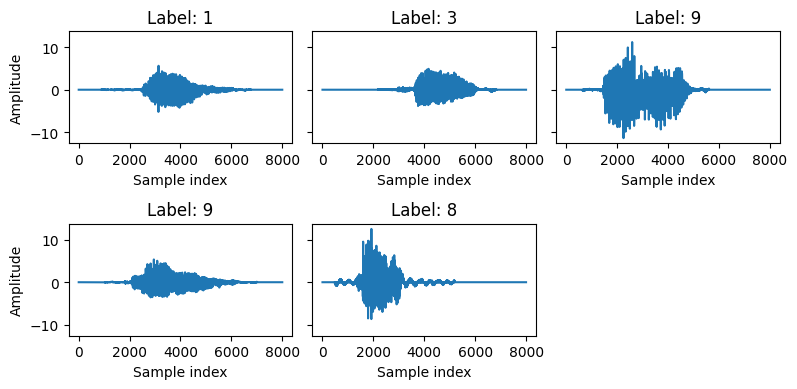

Labels for these audio: [1, 3, 9, 9, 8]


In [108]:
# Visualize a few training audio
audio, labels = next(iter(train_aud_loader)) # audio: Tensor[64,1,8000], labels: Tensor[64]

print("Audio batch shape:", audio.shape)
print("Audio Labels shape:", labels.shape)

audio = audio.cpu().numpy()
labels = labels.cpu().numpy()

# set up a 1×5 grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(8, 4), sharey=True)
axes = axes.flatten()
for i in range(5):
    ax = axes[i]
    # audio[i, 0] is shape (8000,)
    ax.plot(audio[i, 0])
    ax.set_title(f"Label: {labels[i]}")
    ax.set_xlabel("Sample index")
    if i % 3 == 0:
        ax.set_ylabel("Amplitude")

axes[5].axis('off')

plt.tight_layout()
plt.show()

print("Labels for these audio:", labels[:5].tolist())


In [24]:
type(train_img_ds)
type(train_img_loader)

torch.utils.data.dataloader.DataLoader

### Test Loader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.54615486..1.0646734].


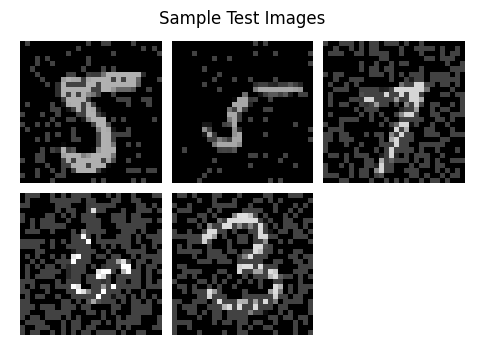

Labels for these images: [5, 5, 7, 6, 3]


In [90]:
imgs, labels = next(iter(test_img_loader))

grid = torchvision.utils.make_grid(imgs[:5], nrow=3, normalize=False, pad_value=1)

plt.figure(figsize=(6,6))
plt.imshow(grid.permute(1,2,0))
plt.title("Sample Test Images")
plt.axis('off')
plt.show()

print("Labels for these images:", labels[:5].tolist())

Audio batch shape: torch.Size([64, 1, 8000])
Audio Labels shape: torch.Size([64])


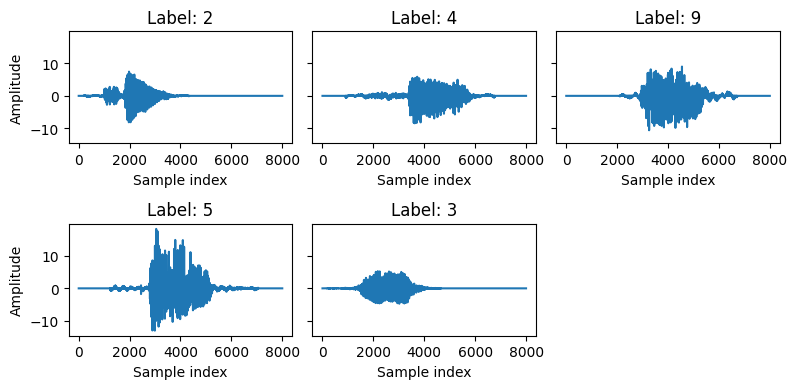

Labels for these audio: [2, 4, 9, 5, 3]


In [109]:
# Visualize a few training audio
audio, labels = next(iter(test_aud_loader)) # audio: Tensor[64,1,8000], labels: Tensor[64]

print("Audio batch shape:", audio.shape)
print("Audio Labels shape:", labels.shape)

audio = audio.cpu().numpy()
labels = labels.cpu().numpy()

# set up a 1×5 grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(8, 4), sharey=True)
axes = axes.flatten()
for i in range(5):
    ax = axes[i]
    # audio[i, 0] is shape (8000,)
    ax.plot(audio[i, 0])
    ax.set_title(f"Label: {labels[i]}")
    ax.set_xlabel("Sample index")
    if i % 3 == 0:
        ax.set_ylabel("Amplitude")

axes[5].axis('off')

plt.tight_layout()
plt.show()

print("Labels for these audio:", labels[:5].tolist())

### Fused Loader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2317789..1.7269084].


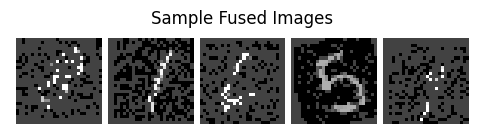

Labels for these images: [8, 1, 6, 5, 9]


In [111]:
(imgs, audio), labels = next(iter(train_fused_loader))

grid = torchvision.utils.make_grid(imgs[:5], nrow=5, normalize=False, pad_value=1)

plt.figure(figsize=(6,6))
plt.imshow(grid.permute(1,2,0))
plt.title("Sample Fused Images")
plt.axis('off')
plt.show()

print("Labels for these images:", labels[:5].tolist())

# Define single encoders

In [113]:
class CNNEncoder(nn.Module):
    """Simple CNN Encoder"""
    def __init__(self):
        super(CNNEncoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64*7*7, 10) #This shape depends on the kernels and the input (split) shape

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc1(x)
        return x

class AudioCNNEncoder(nn.Module):
    """Simple 1D-CNN Encoder for raw waveforms"""
    def __init__(self):
        super(AudioCNNEncoder, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool4 = nn.MaxPool1d(kernel_size=4, stride=4)
        self.fc1 = nn.Linear(64 * 500, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.conv1(x))    # → (batch, 32, 8000)
        x = self.pool4(x)            # → (batch, 32, 2000)
        x = F.relu(self.conv2(x))    # → (batch, 64, 2000)
        x = self.pool4(x)            # → (batch, 64,  500)
        x = x.view(x.size(0), -1)    # → (batch, 64*500)
        x = self.fc1(x)              # → (batch, 10)
        return x



In [ ]:

# Fusing representations
class FusedModel(nn.Module):
    #Implement this in practical
    """Model that fuses CNN and MLP representations."""
    def __init__(self):
        super(FusedModel, self).__init__()
        # FILL IN HERE

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # FILL IN HERE

## Utils

In [114]:
def evaluate(model, loader, criterion, device):
    """
    Run model in eval mode on `loader`, return (avg_loss, accuracy).
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total   = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss    = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            preds        = outputs.argmax(dim=1)
            correct     += (preds == labels).sum().item()
            total       += labels.size(0)

    avg_loss = running_loss / len(loader.dataset)
    acc      = correct / total
    return avg_loss, acc


def train_model(model, train_loader, test_loader, optimizer, criterion, device, num_epochs: int):
    """
    Full training loop:
      - train on train_loader
      - evaluate on test_loader
    Logs train_loss, test_loss, test_acc each epoch.
    Returns a history dict for plotting later.
    """
    history = {
        'train_loss': [],
        'test_loss':  [],
        'test_acc':   []
    }

    model.to(device)

    for epoch in range(1, num_epochs+1):
        # --- Training phase ---
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss    = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        history['train_loss'].append(epoch_train_loss)

        # --- Evaluation phase ---
        epoch_test_loss, epoch_test_acc = evaluate(model, test_loader, criterion, device)
        history['test_loss'].append(epoch_test_loss)
        history['test_acc'].append(epoch_test_acc)

        print(f"Epoch {epoch:2d}/{num_epochs}  "
              f"train_loss: {epoch_train_loss:.4f}  "
              f"test_loss: {epoch_test_loss:.4f}  "
              f"test_acc: {epoch_test_acc:.4f}")

    return history

## Init and train Models

### Image-only training

In [115]:

model       = CNNEncoder().to(device)
optimizer   = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion   = nn.CrossEntropyLoss()
num_epochs  = 5

In [ ]:
history_img = train_model(
    model=model,
    train_loader=train_img_loader,
    test_loader=test_img_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=num_epochs
)

Epoch  1/5  train_loss: 1.6779  test_loss: 0.8348  test_acc: 0.7783
Epoch  2/5  train_loss: 1.0063  test_loss: 0.7312  test_acc: 0.8073
Epoch  3/5  train_loss: 0.8354  test_loss: 0.6167  test_acc: 0.8208
Epoch  4/5  train_loss: 0.7856  test_loss: 0.6180  test_acc: 0.8300
Epoch  5/5  train_loss: 0.7355  test_loss: 0.5596  test_acc: 0.8341


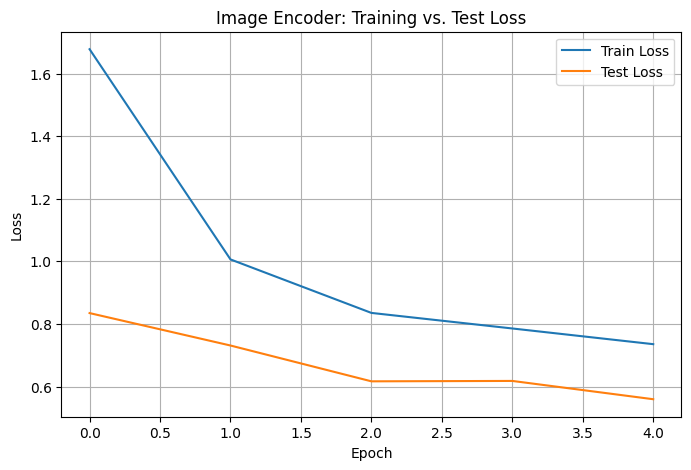

In [123]:

# Loss curve
plt.figure(figsize=(8, 5))
plt.plot(history_img['train_loss'], label='Train Loss')
plt.plot(history_img['test_loss'],  label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Image Encoder: Training vs. Test Loss')
plt.legend()
plt.grid(True)
plt.show()

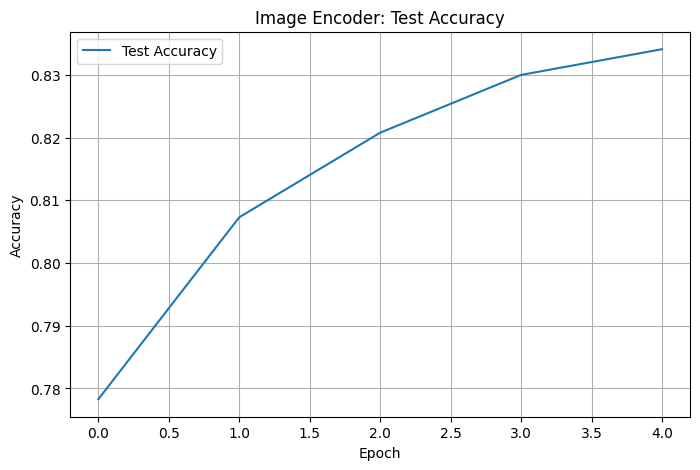

In [124]:
# Accuracy curve
plt.figure(figsize=(8, 5))
plt.plot(history_img['test_acc'], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Image Encoder: Test Accuracy')
plt.legend()
plt.grid(True)
plt.show()


### Audio-only training

In [121]:
model = AudioCNNEncoder().to(device)
optimizer   = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion   = nn.CrossEntropyLoss()
num_epochs  = 5

In [122]:
history_aud = train_model(
    model=model,
    train_loader=train_aud_loader,
    test_loader=test_aud_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=num_epochs
)

Epoch  1/5  train_loss: 2.0393  test_loss: 1.6808  test_acc: 0.4407
Epoch  2/5  train_loss: 1.3528  test_loss: 1.6122  test_acc: 0.4897
Epoch  3/5  train_loss: 1.0169  test_loss: 1.6556  test_acc: 0.5311
Epoch  4/5  train_loss: 0.7740  test_loss: 1.7598  test_acc: 0.5597
Epoch  5/5  train_loss: 0.6063  test_loss: 1.9794  test_acc: 0.5663


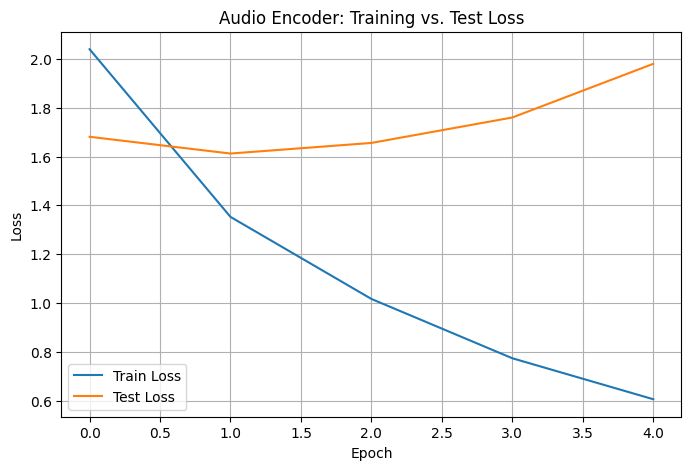

In [125]:
# Audio: Loss curve
plt.figure(figsize=(8, 5))
plt.plot(history_aud['train_loss'], label='Train Loss')
plt.plot(history_aud['test_loss'],  label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Audio Encoder: Training vs. Test Loss')
plt.legend()
plt.grid(True)
plt.show()

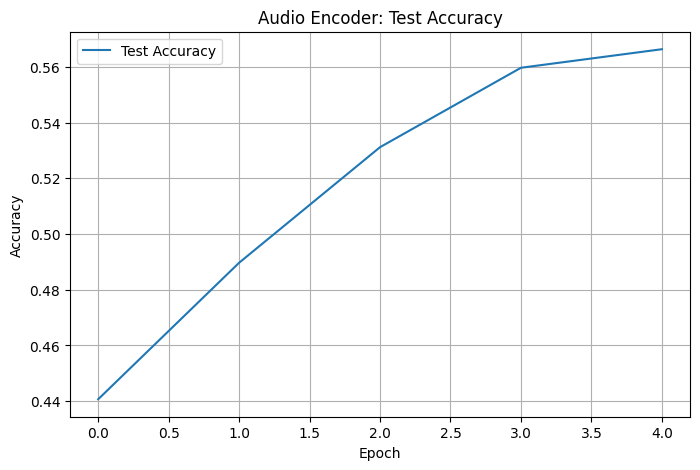

In [126]:
# Audio: Accuracy curve
plt.figure(figsize=(8, 5))
plt.plot(history_aud['test_acc'], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Audio Encoder: Test Accuracy')
plt.legend()
plt.grid(True)
plt.show()


# FusedModels

In [127]:
class EarlyFusionModel(nn.Module):
    def __init__(self):
        super().__init__()
        # image backbone (copy of CNNEncoder up to flatten)
        self.img_conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.img_conv2 = nn.Conv2d(32,64, kernel_size=3, stride=1, padding=1)
        self.img_pool  = nn.MaxPool2d(2)
        
        # audio backbone (copy of AudioCNNEncoder up to flatten) 
        self.aud_conv1 = nn.Conv1d(1, 32, kernel_size=3, stride=1, padding=1)
        self.aud_conv2 = nn.Conv1d(32,64, kernel_size=3, stride=1, padding=1)
        self.aud_pool  = nn.MaxPool1d(4)
        
        fused_dim = 64*7*7 + 64*500
        
        self.classifier = nn.Linear(fused_dim, 10)
    
    def forward(self, img, aud):
        # Image path
        x_img = F.relu(self.img_conv1(img))
        x_img = self.img_pool(x_img)
        x_img = F.relu(self.img_conv2(x_img))
        x_img = self.img_pool(x_img)
        x_img = x_img.view(x_img.size(0), -1)           # [B, 64*7*7]
        
        # Audio path
        x_aud = F.relu(self.aud_conv1(aud))
        x_aud = self.aud_pool(x_aud)
        x_aud = F.relu(self.aud_conv2(x_aud))
        x_aud = self.aud_pool(x_aud)
        x_aud = x_aud.view(x_aud.size(0), -1)           # [B, 64*500]
        
        # Concatenate and classify
        x = torch.cat([x_img, x_aud], dim=1)            # [B, fused_dim]
        out = self.classifier(x)                        # [B, 10]
        return out
    

class LateFusionModel(nn.Module):
    def __init__(self, img_encoder:nn.Module, aud_encoder:nn.Module):
        super().__init__()
        # take your pretrained/initialized encoders
        self.img_encoder = img_encoder
        self.aud_encoder = aud_encoder
    
    def forward(self, img, aud):
        # get each modality’s raw logits
        logits_img = self.img_encoder(img)      # [B,10]
        logits_aud = self.aud_encoder(aud)      # [B,10]
        
        # simple average fusion
        out = (logits_img + logits_aud) / 2
        return out


## Utils

In [128]:
def evaluate_fused(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total   = 0
    
    with torch.no_grad():
        for (imgs, audios), labels in loader:
            imgs, audios, labels = imgs.to(device), audios.to(device), labels.to(device)
            outputs = model(imgs, audios)
            loss    = criterion(outputs, labels)
            
            running_loss += loss.item() * labels.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total   += labels.size(0)
    
    avg_loss = running_loss / len(loader.dataset)
    acc      = correct / total
    return avg_loss, acc


def train_model_fused(model, train_loader, test_loader, optimizer, criterion, device, num_epochs: int):
    history = {'train_loss': [], 'test_loss': [], 'test_acc': []}
    model.to(device)

    for epoch in range(1, num_epochs+1):
        model.train()
        running_loss = 0.0
        
        for (imgs, audios), labels in train_loader:
            imgs, audios, labels = imgs.to(device), audios.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(imgs, audios)
            loss    = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * labels.size(0)
        
        train_loss = running_loss / len(train_loader.dataset)
        history['train_loss'].append(train_loss)
        
        # ——— Evaluation ———
        test_loss, test_acc = evaluate_fused(model, test_loader, criterion, device)
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)
        
        print(f"Epoch {epoch}/{num_epochs} "
              f"train_loss={train_loss:.4f} "
              f"test_loss={test_loss:.4f} "
              f"test_acc={test_acc:.4f}")
    
    return history

## Init and train FusedModels

### Early Fusion

In [129]:
# Early fusion
fused_model = EarlyFusionModel().to(device)
opt = torch.optim.Adam(fused_model.parameters(), lr=1e-3)

hist_early = train_model_fused(
    fused_model,
    train_fused_loader,
    test_fused_loader,
    opt,
    nn.CrossEntropyLoss(),
    device,
    num_epochs=5
)


Epoch 1/5 train_loss=1.8976 test_loss=0.8769 test_acc=0.7611
Epoch 2/5 train_loss=0.8142 test_loss=0.5684 test_acc=0.8460
Epoch 3/5 train_loss=0.5021 test_loss=0.5813 test_acc=0.8442
Epoch 4/5 train_loss=0.3898 test_loss=0.5925 test_acc=0.8599
Epoch 5/5 train_loss=0.3219 test_loss=0.6009 test_acc=0.8686


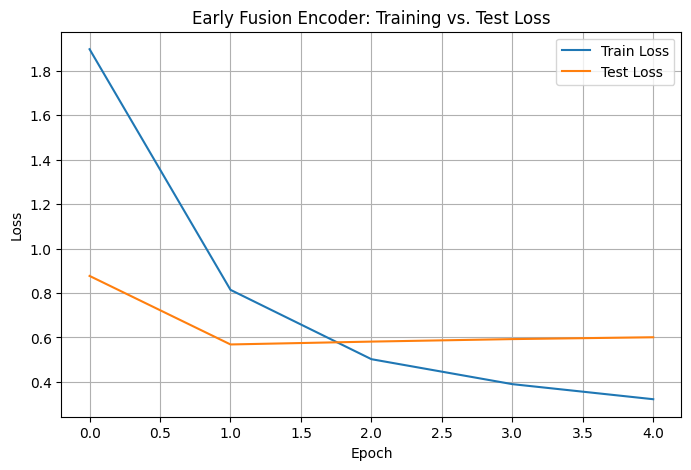

In [131]:
# Early fusion: Loss curve
plt.figure(figsize=(8, 5))
plt.plot(hist_early['train_loss'], label='Train Loss')
plt.plot(hist_early['test_loss'],  label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Early Fusion Encoder: Training vs. Test Loss')
plt.legend()
plt.grid(True)
plt.show()

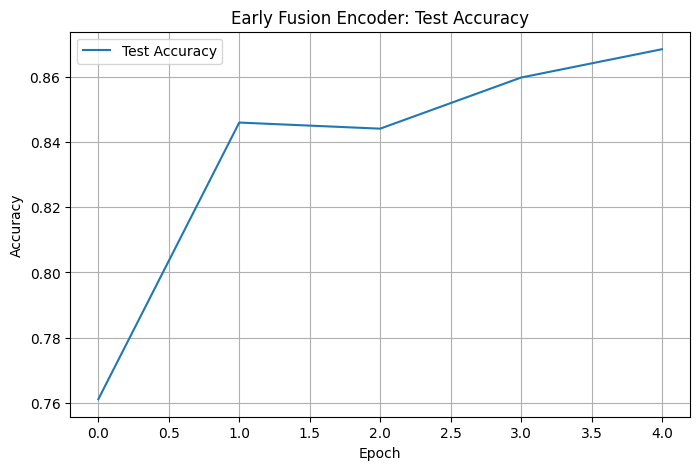

In [132]:
# Early fusion: Accuracy curve
plt.figure(figsize=(8, 5))
plt.plot(hist_early['test_acc'], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Early Fusion Encoder: Test Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### Late Fusion

In [130]:
# Late fusion
late_model = LateFusionModel(CNNEncoder(), AudioCNNEncoder()).to(device)
opt_late   = torch.optim.Adam(late_model.parameters(), lr=1e-3)

hist_late  = train_model_fused(
    late_model,
    train_fused_loader,
    test_fused_loader,
    opt_late,
    nn.CrossEntropyLoss(),
    device,
    num_epochs=5
)

Epoch 1/5 train_loss=1.7423 test_loss=0.8717 test_acc=0.7535
Epoch 2/5 train_loss=0.7826 test_loss=0.5347 test_acc=0.8658
Epoch 3/5 train_loss=0.4562 test_loss=0.5315 test_acc=0.8619
Epoch 4/5 train_loss=0.3328 test_loss=0.5911 test_acc=0.8507
Epoch 5/5 train_loss=0.2667 test_loss=0.5860 test_acc=0.8848


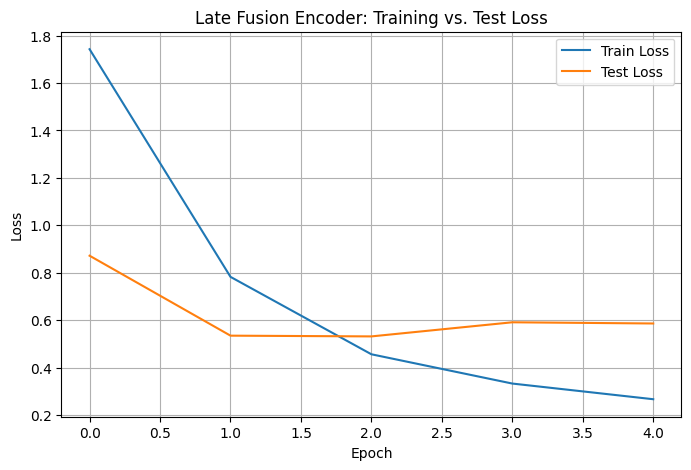

In [133]:
# Late fusion: Loss curve
plt.figure(figsize=(8, 5))
plt.plot(hist_late['train_loss'], label='Train Loss')
plt.plot(hist_late['test_loss'],  label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Late Fusion Encoder: Training vs. Test Loss')
plt.legend()
plt.grid(True)
plt.show()

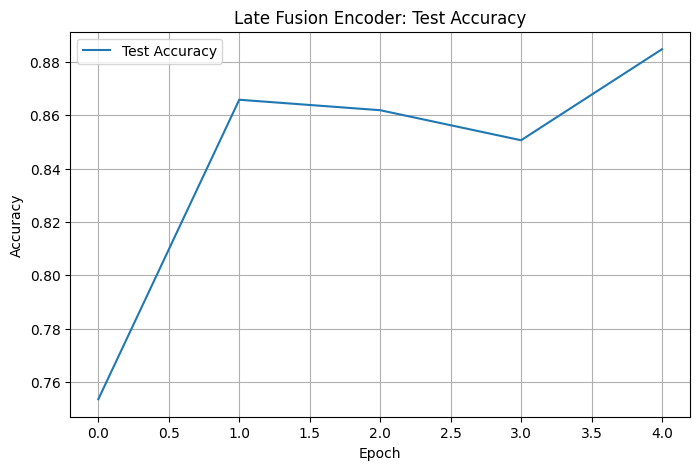

In [ ]:
# Late fusion: Accuracy curve
plt.figure(figsize=(8, 5))
plt.plot(hist_late['test_acc'], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Late Fusion Encoder: Test Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Representation Visualizations

In [143]:
def get_representations(model, loader, device):
    """
    For each (img,aud), returns:
      • img_logits:    N×D
      • aud_logits:    N×D
      • fused_logits:  N×D
      • labels:        N
    Shows a progress bar over batches.
    """
    model.to(device).eval()
    all_img, all_aud, all_fused, all_lbls = [], [], [], []
    
    with torch.no_grad():
        for (imgs, auds), labels in tqdm(loader,
                                          desc="Extracting reps",
                                          unit="batch"):
            imgs, auds, labels = imgs.to(device), auds.to(device), labels.to(device)
            
            # forward each branch
            lg_img   = model.img_encoder(imgs)      # B×D
            lg_aud   = model.aud_encoder(auds)      # B×D
            lg_fused = (lg_img + lg_aud) / 2        # B×D
            
            all_img.append(lg_img.cpu().numpy())
            all_aud.append(lg_aud.cpu().numpy())
            all_fused.append(lg_fused.cpu().numpy())
            all_lbls.append(labels.cpu().numpy())
    
    img_feats   = np.concatenate(all_img,   axis=0)
    aud_feats   = np.concatenate(all_aud,   axis=0)
    fused_feats = np.concatenate(all_fused, axis=0)
    labels      = np.concatenate(all_lbls,  axis=0)
    return img_feats, aud_feats, fused_feats, labels

In [145]:
from tqdm import tqdm


In [146]:
img_feats, aud_feats, fused_feats, labels = get_representations(
    late_model,
    test_fused_loader,
    device
)

Extracting reps: 100%|██████████| 92/92 [00:01<00:00, 58.57batch/s]


In [147]:
5859/64

91.546875

In [148]:
def plot_scatter(X2d, labels, title, xlabel, ylabel):
    plt.figure(figsize=(6,6))
    for digit in np.unique(labels):
        idxs = labels == digit
        plt.scatter(
            X2d[idxs,0],
            X2d[idxs,1],
            label=str(digit),
            alpha=0.6
        )
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()


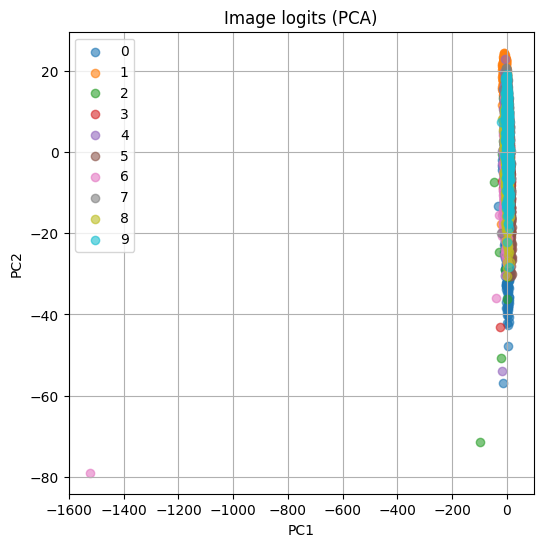

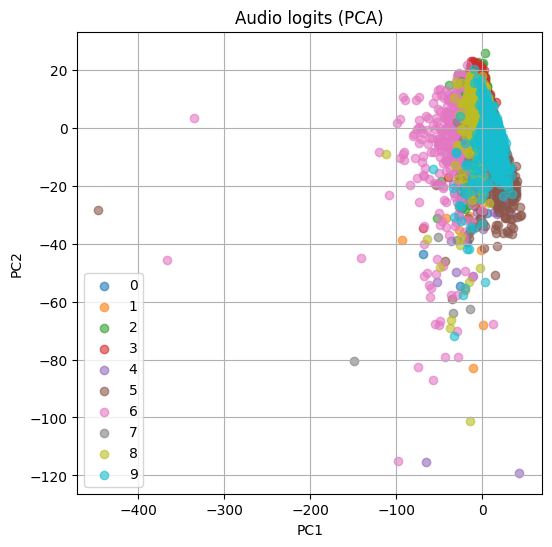

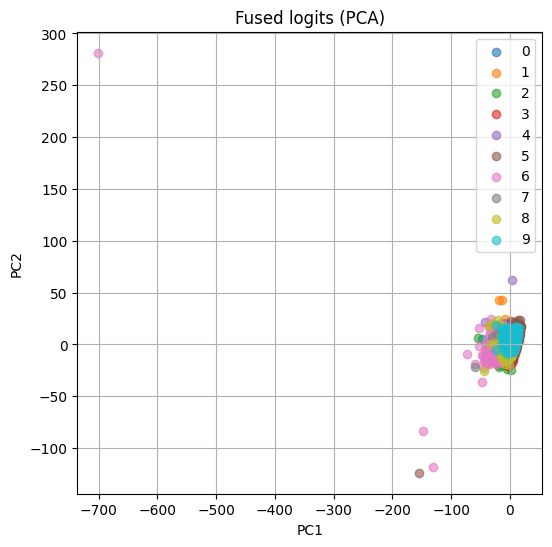

In [149]:

# PCA
pca = PCA(n_components=2)
for feats, name in [(img_feats,'Image'), (aud_feats,'Audio'), (fused_feats,'Fused')]:
    red = pca.fit_transform(feats)
    plot_scatter(
        red, labels,
        title=f"{name} logits (PCA)",
        xlabel="PC1", ylabel="PC2"
    )


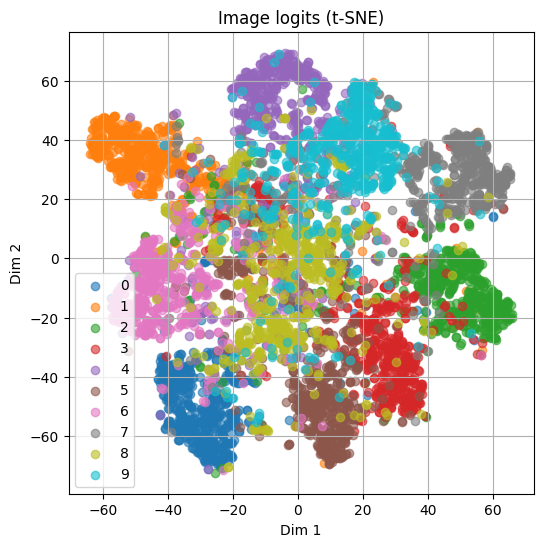

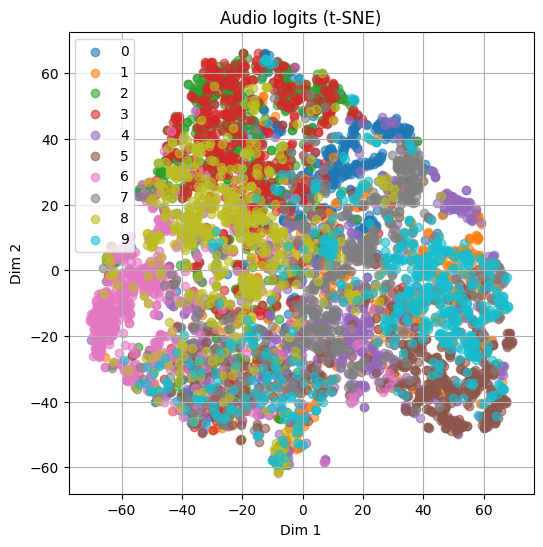

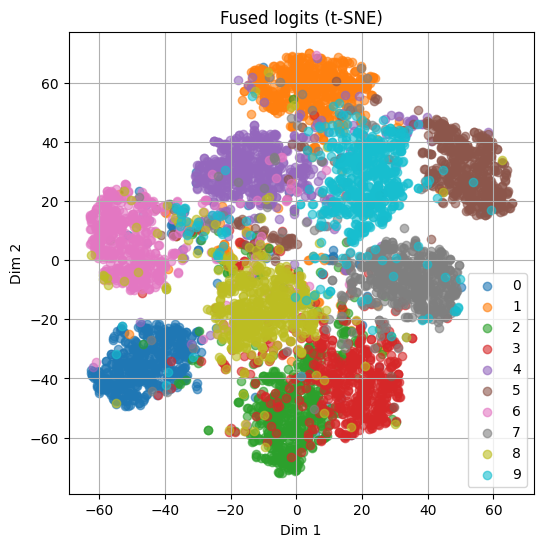

In [150]:

# t-SNE (takes longer—consider subsampling)
tsne = TSNE(n_components=2, random_state=0, init='pca', learning_rate='auto')
for feats, name in [(img_feats,'Image'), (aud_feats,'Audio'), (fused_feats,'Fused')]:
    red = tsne.fit_transform(feats)   # you might do feats[:2000] here
    plot_scatter(
        red, labels,
        title=f"{name} logits (t-SNE)",
        xlabel="Dim 1", ylabel="Dim 2"
    )